In [1]:
%reload_ext autoreload
%autoreload 2

## Read the data

In [2]:
from npfd import data

X_train, X_val, y_train, y_val = data.dataset.make_dataset('db1', clean_interim_dir=True)
X_adapt, X_test, y_adapt, y_test = data.dataset.make_dataset('db3', test_size=0.3, clean_interim_dir=False)

INFO:root:Converting malte-uhma raw files to HTK format ...
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Generating script (.scp) files...
INFO:root:Generating Master Label File (Train)...
INFO:root:Generating Master Label File (Test)...
INFO:root:Adding deltas and acelerations...
INFO:root:Test files:	168.0
INFO:root:Train files:	1434.0
INFO:root:Converting real raw files to HTK format ...
INFO:root:Generating Master Label File (Train)...
INFO:root:Generating Master Label File (Test)...


## Train and evaluation

In [36]:
from npfd.models.base import HiddenMarkovModel

        
def train_evaluate(X_train, X_val, y_train, y_val, X_adapt, X_test, y_adapt, y_test,**kwargs):

    model = HiddenMarkovModel()
    model.initialize(X_train, init_method='HCompV', **kwargs)

    model.train(X_train, y_train, **kwargs)
   
    for _ in range(kwargs['gaussian_duplication_times']):
        model.edit([f'MU +2 {{*.state[2-4].mix}}'])
        model.train(X_train, y_train, **kwargs)

    model.adapt(X_adapt, y_adapt)

    results = model.test(X_test, y_test, **kwargs)

    return results['WORD_Acc']

## Define the hyperparameter space to search

The list of hyper-parameters we want to optimize. For each one we define the bounds, the corresponding scikit-learn parameter name, as well as how to sample values from that dimension (`'log-uniform'` for the learning rate)

In [45]:
import skopt

space = [
    skopt.space.Real(1e-3, 0.1, name='variance_floor', prior='log-uniform'),
    skopt.space.Real(1e-3, 0.1, name='minimum_variance', prior='log-uniform'),
    skopt.space.Real(0.0, 30.0, name='word_insertion_penalty', prior='uniform'),
    skopt.space.Real(0.0, 30.0, name='grammar_scale_factor', prior='uniform'),
    skopt.space.Integer(2, 7, name='gaussian_duplication_times')
]

This decorator allows your objective function to receive a the parameters as keyword arguments. This is particularly convenient when you want to set scikit-learn estimator parameters

In [38]:
@skopt.utils.use_named_args(space)
def objective(**params):
    return -1.0 * train_evaluate(X_train, X_val, y_train, y_val, X_adapt, X_test, y_adapt, y_test, **params)

Run the optimizer

In [39]:
results = skopt.gp_minimize(objective, space, n_calls=50)

best_auc = -1.0 * results.fun
best_params = results.x

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Adapting model 15


Pruning-Off



INFO:root:Testing model: 15
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 42 XFormInfo structures
Attached 42 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.302431e+00
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.059576e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = 1.043717e+01
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = 2.358900e+01
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 2.612862e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -2.999588e+01
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 3.075405e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -5.

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/hmmdefs -p 22.5635556075 -s 6.3673038327 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:21:15 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -2.040961e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.643504e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -2.928456e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -3.518964e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -1.744726e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -2.936740e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.030395e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 17.4384499317 -s 27.9154900233 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:22:19 2021


INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = 3.934358e+01
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.432166e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = 2.088698e+00
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = 2.228642e+01
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 7.537133e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.302199e+01
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 8.060979e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -5.5

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 0.2146907327 -s 28.9161393085 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:23:22 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Adapting model 19


Pruning-Off



INFO:root:Testing model: 19
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 54 XFormInfo structures
Attached 54 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -3.977184e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -5.908767e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.703990e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -2.733007e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 8.919416e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.091065e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 4.096342e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/19/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/19/hmmdefs -p 17.7040438190 -s 23.3059878030 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:23:55 2021


INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Adapting model 15


Pruning-Off



INFO:root:Testing model: 15
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 42 XFormInfo structures
Attached 42 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.776171e+01
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -3.682556e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = 1.489395e+01
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = 2.189503e+01
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 4.455659e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.009890e+01
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 6.586386e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -1.

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/hmmdefs -p 11.5049075601 -s 21.7942755533 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:24:21 2021


INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.233186e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -7.334531e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -8.156816e+01
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.762324e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 8.867293e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.238217e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 6.631626e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 6.0945244366 -s 21.4902487190 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:25:26 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Adapting model 23


Pruning-Off



INFO:root:Testing model: 23
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 66 XFormInfo structures
Attached 66 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = 2.606637e+00
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -3.336034e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = 6.660361e+00
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = 2.069627e+01
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 4.799023e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -5.993688e+01
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 5.255591e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -9.5

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/23/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/23/hmmdefs -p 24.1898568425 -s 6.2957522592 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:26:15 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Adapting model 15


Pruning-Off



INFO:root:Testing model: 15
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 42 XFormInfo structures
Attached 42 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.735119e+00
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.299846e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = 9.110390e+00
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = 2.386777e+01
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 2.803762e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.378330e+01
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 3.244512e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -5.

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/hmmdefs -p 20.0888278308 -s 27.7951064127 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:26:43 2021


INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -2.519029e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.936688e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.634060e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -4.203710e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -1.991511e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.404498e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.313426e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 6.1622536677 -s 20.7796660801 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:27:34 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = 1.442196e-02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -7.659067e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -2.602077e+01
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -8.775748e+01
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 8.896075e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -2.592808e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 9.161510e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -1

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 12.9046836091 -s 4.0257695976 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:27:53 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Adapting model 19


Pruning-Off



INFO:root:Testing model: 19
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 54 XFormInfo structures
Attached 54 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -7.750123e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -4.839872e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -6.339270e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -8.781469e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 9.771342e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -4.273045e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.263780e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/19/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/19/hmmdefs -p 0.8619055817 -s 28.4758688290 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:28:25 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -5.208440e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -5.555882e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -6.391258e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -8.164252e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 7.049238e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.175618e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.285993e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 12.6634353362 -s 23.9543244608 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:29:19 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -5.436681e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.010125e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -4.173510e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -5.470582e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 4.108205e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.528480e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -5.308972e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 21.8197520925 -s 17.0591995052 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:30:11 2021


INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -3.646689e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.060357e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.618005e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -4.921459e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 3.534123e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.699416e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -2.588445e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 21.4189113514 -s 1.8285305598 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:31:15 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -5.870691e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -6.247119e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -7.202161e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -9.191606e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 6.214703e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.956240e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.587508e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 4.2022943652 -s 29.5056111422 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:32:07 2021
 

INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Adapting model 23


Pruning-Off



INFO:root:Testing model: 23
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 66 XFormInfo structures
Attached 66 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -3.240401e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.302285e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -9.315589e+01
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.525923e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 4.459907e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -4.899566e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 2.441207e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/23/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/23/hmmdefs -p 20.3538174751 -s 13.3460582114 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:32:51 2021


INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -5.988253e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -5.676211e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -6.704100e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -8.143670e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 6.845480e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.295041e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.349828e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 25.0789813205 -s 1.0959423990 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:33:43 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -5.521932e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.087014e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -4.773018e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -6.074486e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 3.069967e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -8.436863e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -6.761664e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 14.1988593651 -s 18.4828250971 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:34:35 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -5.032494e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.054135e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -4.767832e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -6.028475e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 5.092784e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -8.456348e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -6.425046e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 13.9825498303 -s 19.2198422596 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:35:28 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.934468e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -5.682045e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -4.894299e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -6.154879e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 1.011608e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -4.685156e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -6.768895e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 13.7375577315 -s 20.2498091397 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:36:20 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.029111e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -3.191120e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -5.092566e+01
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.208047e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 9.959462e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -1.533505e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 7.400748e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 22.5421172682 -s 14.6337655082 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:37:25 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -2.858972e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -8.621078e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -2.788903e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -4.074728e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 4.653315e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -6.293305e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 4.531540e+00
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 14.5736080920 -s 18.0603839983 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:38:17 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -3.242752e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -3.290675e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -4.569059e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -5.143958e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -2.827865e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -4.119883e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.673811e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 6.8602067633 -s 22.2322120216 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:39:21 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.195887e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.125901e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -4.314282e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -5.617975e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 3.114947e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -8.455909e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -5.144022e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 13.9035674015 -s 22.5708252488 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:40:25 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.789792e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.304315e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -5.641754e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -6.932003e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 6.147449e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -8.889636e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -9.265675e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 14.5195782487 -s 17.6043767706 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:41:17 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -6.564492e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -5.389742e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -9.480892e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.088063e+04
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -5.927470e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.962306e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -3.732602e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 9.9863602611 -s 30.0000000000 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:42:22 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Adapting model 15


Pruning-Off



INFO:root:Testing model: 15
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 42 XFormInfo structures
Attached 42 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.155155e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -5.537180e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.552577e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -2.289120e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 8.223716e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -2.606052e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 4.143433e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/hmmdefs -p 29.8524761043 -s 4.1038037622 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:42:47 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -5.943109e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.258783e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.873835e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -5.784877e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 9.512549e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.055374e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -4.564959e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 1.4744529264 -s 3.3067195298 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:43:05 2021
  

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.908093e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.050875e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.163403e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -2.425087e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 6.597432e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -5.289339e+01
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.067848e+00
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 1.8021720564 -s 16.1864139194 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:43:24 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.349984e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.883489e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.746129e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -2.012929e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -5.144359e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -1.781418e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -5.639475e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 27.5513573476 -s 12.6537919298 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:44:17 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.714297e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.197755e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.081389e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -2.205145e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 6.719288e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -6.244465e+01
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 1.014492e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 24.4457429825 -s 1.8520159283 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:44:36 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.106270e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -6.464374e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -2.059746e+01
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -5.136544e+01
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 7.212703e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -2.464478e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 7.126476e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 1.5884367567 -s 1.0312519387 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:45:31 2021
  

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -7.190193e+01
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.628232e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.736438e+01
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.390876e+01
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 7.049541e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -4.654330e+01
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = 4.116717e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = -

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 29.9323001031 -s 9.4430867539 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:46:41 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -7.854830e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -4.132209e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.106261e+04
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.263038e+04
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -7.041922e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.833082e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -4.403739e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 18.0453810698 -s 6.9876389936 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:47:00 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -2.544245e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.933562e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.478929e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -3.980298e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -1.391013e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.429677e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.257363e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 2.1092249547 -s 13.5453831057 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:47:19 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Adapting model 15


Pruning-Off



INFO:root:Testing model: 15
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 42 XFormInfo structures
Attached 42 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -8.420464e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.567878e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -7.861222e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -9.947491e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 8.191420e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -1.043518e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.726631e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/hmmdefs -p 1.9267864798 -s 27.3147716930 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:47:44 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Adapting model 23


Pruning-Off



INFO:root:Testing model: 23
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 66 XFormInfo structures
Attached 66 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -7.611138e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -6.133445e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.099052e+04
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.254503e+04
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -6.954311e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -9.134813e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -4.350617e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/23/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/23/hmmdefs -p 6.3296979217 -s 2.6502638439 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:48:27 2021
  

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.004134e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.774636e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -5.584225e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -6.355343e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -2.828719e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -4.300279e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -2.115674e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 13.2475486817 -s 0.6737761645 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:48:45 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -8.270175e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -6.379740e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.180508e+04
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.361721e+04
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -7.665477e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -9.780177e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -4.710528e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 8.9067369821 -s 0.5269779979 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:49:52 2021
  

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -6.213892e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -3.574975e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -8.735820e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -9.933201e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -5.235029e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -6.349573e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -3.426265e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 3.0147527552 -s 6.0259990435 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:50:11 2021
  

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -2.420645e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.860260e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.300433e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -3.777935e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -1.274791e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.305680e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.184684e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 6.2702210397 -s 27.0885298763 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:50:29 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Adapting model 15


Pruning-Off



INFO:root:Testing model: 15
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 42 XFormInfo structures
Attached 42 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.215475e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -3.855367e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -5.908760e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -6.709617e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -3.026825e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -5.049622e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -2.238894e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/hmmdefs -p 1.7151316360 -s 22.2330460461 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:50:54 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Adapting model 15


Pruning-Off



INFO:root:Testing model: 15
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 42 XFormInfo structures
Attached 42 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -8.410071e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -4.781808e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.184281e+04
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.358630e+04
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -7.509388e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -8.746019e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -4.722370e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/15/hmmdefs -p 29.4717223266 -s 27.0935911749 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:51:20 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -2.549987e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.837115e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.508631e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -3.968381e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -1.984893e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.283058e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.262614e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 0.3644461385 -s 28.6658481757 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:52:26 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -2.571251e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.946299e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.518851e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -4.023192e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -1.413075e+02
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -3.456022e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.272666e+03
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 28.8052830237 -s 3.9442369788 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:52:45 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Adapting model 27


Pruning-Off



INFO:root:Testing model: 27
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 78 XFormInfo structures
Attached 78 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -4.336509e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -9.843064e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.817024e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -5.028181e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 4.449252e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -7.258069e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -3.186263e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/27/hmmdefs -p 2.4186059264 -s 29.4781770277 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:53:38 2021
 

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.331158e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.822500e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.572177e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.779134e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 4.042648e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -1.522292e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -4.449152e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 29.5835731753 -s 10.8448978532 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:53:57 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Adapting model 11


Pruning-Off



INFO:root:Testing model: 11
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 30 XFormInfo structures
Attached 30 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -2.179095e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -2.172987e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -2.804858e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -3.052607e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = -4.586912e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -2.368374e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -9.582410e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame =

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/11/hmmdefs -p 24.3950913370 -s 28.5078305727 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:54:15 2021


INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Editing model 23
INFO:root:Most trained model: 24
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 11 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 66 to 78

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 27
INFO:root:Editing model 27
INFO:root:Most trained model: 28
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 13 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 78 to 90

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 31
INFO:root:Adapting model 31


Pruning-Off



INFO:root:Testing model: 31
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 90 XFormInfo structures
Attached 90 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -3.166531e+02
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -9.304406e+02
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -3.262794e+02
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -4.692341e+02
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 4.366312e+01
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -6.848919e+02
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -1.235193e+01
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/31/hmmdefs -p 6.1513987604 -s 2.7883451832 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:55:19 2021
  

INFO:root:Initializing model...
INFO:root:/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc
INFO:root:Training the model...


Calculating Fixed Variance
  HMM Prototype: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
206496 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0
Var floor macros output to file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/0/vFloors

/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/notebooks/results
Pruning-Off

Pruning-Off



INFO:root:Most trained model: 3
INFO:root:Editing model 3
INFO:root:Most trained model: 4
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 6 to 18

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 7
INFO:root:Editing model 7
INFO:root:Most trained model: 8
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 3 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 18 to 30

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 11
INFO:root:Editing model 11
INFO:root:Most trained model: 12
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 5 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 30 to 42

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 15
INFO:root:Editing model 15
INFO:root:Most trained model: 16
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 7 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 42 to 54

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 19
INFO:root:Editing model 19
INFO:root:Most trained model: 20
INFO:root:Training the model...


Pruning-Off

HHEd
 2/2 Models Loaded [5 states max, 9 mixes max]

MU +2 {}
 Mixup by 2 components per stream
 MU: Number of mixes increased from 54 to 66

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off



INFO:root:Most trained model: 23
INFO:root:Adapting model 23


Pruning-Off



INFO:root:Testing model: 23
INFO:root:Testing real data


HERest  ML Updating: XForms 

 System is PLAIN
2 Logical/2 Physical Models Loaded, VecSize=75
2 MMF input files
  Using baseclass macro "global" from file /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes/global
Attached 66 XFormInfo structures
Attached 66 RegAcc structures
Pruning-Off
 Processing Data: 20170504; Label 20170504.lab
 Utterance prob per frame = -1.122555e+03
 Processing Data: 20170518; Label 20170518.lab
 Utterance prob per frame = -1.417854e+03
 Processing Data: 20171227; Label 20171227.lab
 Utterance prob per frame = -1.418262e+03
 Processing Data: 20171101; Label 20171101.lab
 Utterance prob per frame = -1.638049e+03
 Processing Data: 20170103; Label 20170103.lab
 Utterance prob per frame = 9.821402e+00
 Processing Data: 20170917; Label 20170917.lab
 Utterance prob per frame = -1.344794e+03
 Processing Data: 20171213; Label 20171213.lab
 Utterance prob per frame = -4.218810e+02
 Processing Data: 20170316; Label 20170316.lab
 Utterance prob per frame = 

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/config -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/23/macros -H /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/hmm/23/hmmdefs -p 2.0436455005 -s 4.5221487932 -A -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/classes -J /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/models/xforms mllr1 -h */%* -k -w /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/wdnet -S /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/dmps_test_D_A.scp -i /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/data/interim/results.mlf /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/dict /home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul  1 00:56:01 2021
  

In [40]:
"Best score=%.4f" % (results.fun * -1.0)

'Best score=50.8700'

In [47]:
print("""Best parameters:
- variance_floor=%.6f
- minimum_variance=%.6f
- word_insertion_penalty=%.2f
- grammar_scale_factor=%.2f
- min_samples_leaf=%d""" % (results.x[0], results.x[1],
                            results.x[2], results.x[3],
                            results.x[3]))

Best parameters:
- variance_floor=0.002267
- minimum_variance=0.042894
- word_insertion_penalty=1.47
- grammar_scale_factor=3.31
- min_samples_leaf=3


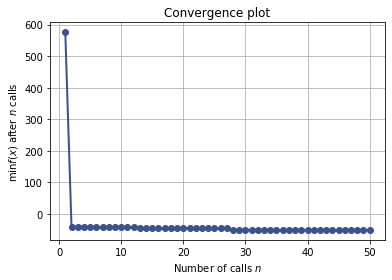

In [42]:
from skopt.plots import plot_convergence

plot_convergence(results)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4fce4d710>,
      dtype=object)

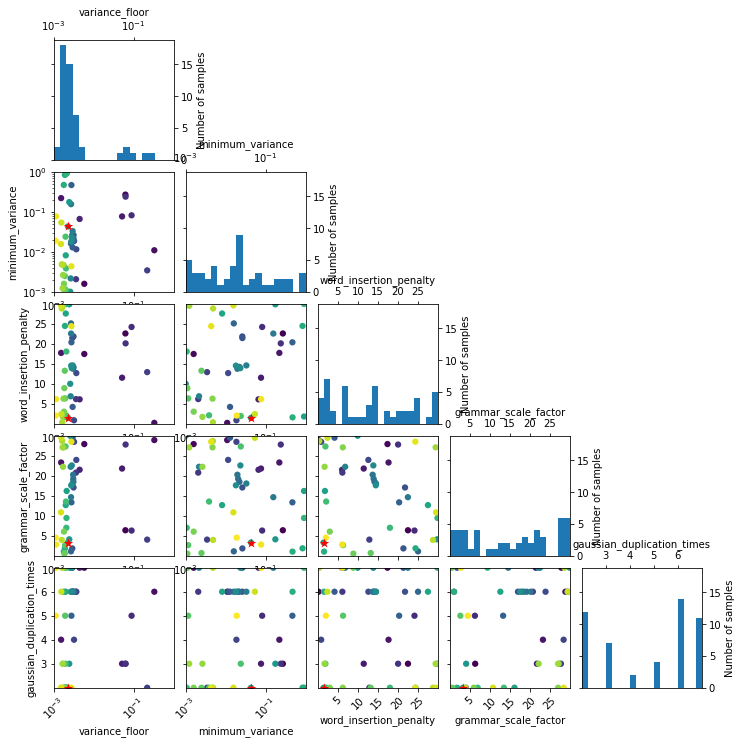

In [43]:
skopt.plots.plot_evaluations(results)

[autoreload of npfd.features.scripts failed: Traceback (most recent call last):
  File "/home/gfogwil/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/gfogwil/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/home/gfogwil/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/gfogwil/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/gfogwil/Documentos/Facultad/Tesis/models/bdb/npfd/features/scripts.py", line 12, in <module>
    client = Client(HOST)
  File "/home/gfogwil/anaconda3/

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4bfbfd510>,
      dtype=object)

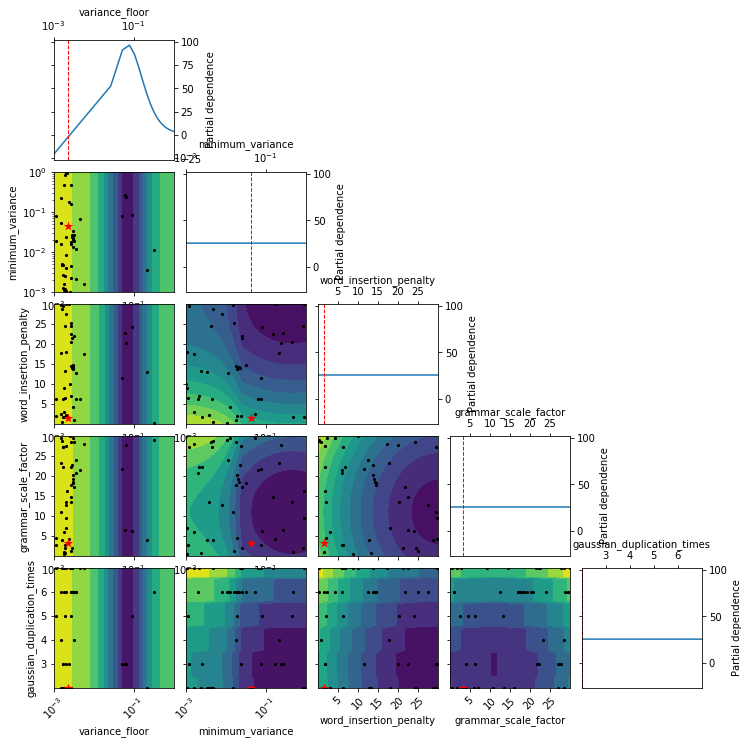

In [44]:
skopt.plots.plot_objective(results)